# **Testing Keras RNN Models on the Orderbook dataset**

This notebook uses code/functions from the following tutorials -

https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

https://keras.io/api/data_loading/timeseries/

## **Load Imports and Data**

In [1]:
from sklearn.preprocessing import MinMaxScaler
import IPython
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

MAX_EPOCHS = 2000

Mounted at /content/drive


In [2]:
training_data_path = '/content/drive/MyDrive/orderbook_snapshots.csv'
df_training = pd.read_csv(training_data_path)
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7825199 entries, 0 to 7825198
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   2024-02-07 09:00:00  object 
 1   57                   int64  
 2   2367.3               float64
 3   2.03941              float64
 4   49_ask               object 
dtypes: float64(2), int64(1), object(2)
memory usage: 298.5+ MB


In [3]:
# CREDIT: Sinas code to load data

# Load the data
# Input and output file names
output_filename = '/content/drive/My Drive/reformatted.csv'

# Initialise a dictionary to hold the data in correct order
orders = defaultdict(lambda: {'ask_price': None, 'ask_qty': None, 'bid_price': None, 'bid_qty': None})

# Read original csv and populate the orders dictionary
with open(training_data_path, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        timestamp, _, price, quantity, order_type = row
        if order_type == '0_ask':
            orders[timestamp]['ask_price'] = price
            orders[timestamp]['ask_qty'] = quantity
        elif order_type == '0_bid':
            orders[timestamp]['bid_price'] = price
            orders[timestamp]['bid_qty'] = quantity

# Write the data to a new csv file
with open(output_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', 'Best Ask Price Level', 'Best Ask Quantity', 'Best Bid Price Level', 'Best Bid Quantity'])
    for timestamp, order in orders.items():
        writer.writerow([timestamp, order['ask_price'], order['ask_qty'], order['bid_price'], order['bid_qty']])

data_path = output_filename
columns = ['timestamp', 'best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']
data = pd.read_csv(data_path, header=None, names=columns, skiprows=1)

# Convert timestamp to a numerical format
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y.%m.%d %H:%M:%S')
# Normalize the dataset
scaler = MinMaxScaler()
data[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']] = \
    scaler.fit_transform(data[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']])

date_time = data.pop('timestamp')

data.head()


,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
0,0.097639,0.006994,0.10075,0.005718
1,0.097639,0.009870,0.10075,0.006075
2,0.097639,0.009708,0.10075,0.005741
3,0.097639,0.009935,0.10075,0.006075
4,0.097639,0.010097,0.10075,0.006075


In [4]:
# Split the dataset into training, val and test

column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]

train_df.head()

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
0,0.097639,0.006994,0.10075,0.005718
1,0.097639,0.009870,0.10075,0.006075
2,0.097639,0.009708,0.10075,0.005741
3,0.097639,0.009935,0.10075,0.006075
4,0.097639,0.010097,0.10075,0.006075


## **Data Windowing Functions**


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='best_ask_price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Generate baseline model

In [ ]:
# Single step window generator
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['best_ask_price'])
single_step_window

# Baseline Model
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['best_ask_price'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

490/490 [==============================] - 2s 3ms/step - loss: 1.6155e-06 - mean_absolute_error: 4.5540e-04


## **Create Linear & LSTM Models**

In [ ]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['best_ask_price'])

wide_window


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['best_ask_price']

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/2000
1712/1712 [==============================] - 10s 5ms/step - loss: 0.0645 - mean_absolute_error: 0.1750 - val_loss: 0.0032 - val_mean_absolute_error: 0.0520
Epoch 2/2000
1712/1712 [==============================] - 10s 6ms/step - loss: 9.2220e-04 - mean_absolute_error: 0.0200 - val_loss: 8.0238e-05 - val_mean_absolute_error: 0.0027
Epoch 3/2000
1712/1712 [==============================] - 7s 4ms/step - loss: 2.9255e-05 - mean_absolute_error: 0.0022 - val_loss: 4.6597e-06 - val_mean_absolute_error: 0.0011
Epoch 4/2000
1712/1712 [==============================] - 9s 5ms/step - loss: 4.7901e-06 - mean_absolute_error: 0.0011 - val_loss: 1.8196e-06 - val_mean_absolute_error: 8.0548e-04
Epoch 5/2000
1712/1712 [==============================] - 9s 5ms/step - loss: 4.3201e-06 - mean_absolute_error: 0.0011 - val_loss: 2.0350e-06 - val_mean_absolute_error: 9.4626e-04
Epoch 6/2000
490/490 [==============================] - 2s 5ms/step - loss: 2.0547e-06 - mean_absolute_error: 9.5794e-

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


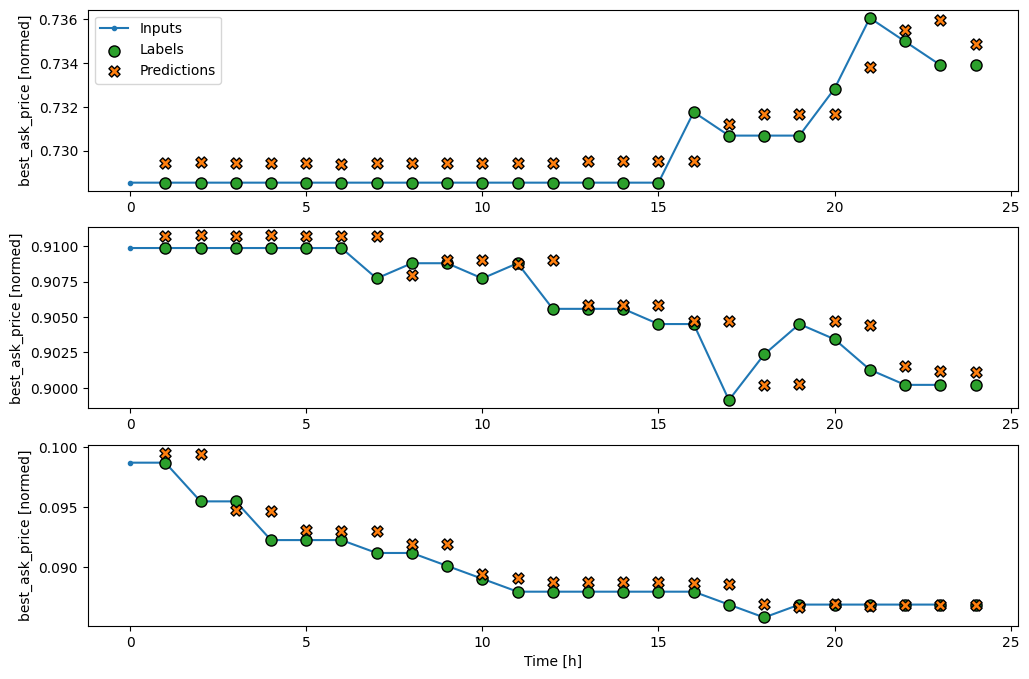

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(linear)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

489/489 [==============================] - 3s 6ms/step - loss: 2.0791e-06 - mean_absolute_error: 8.7133e-04


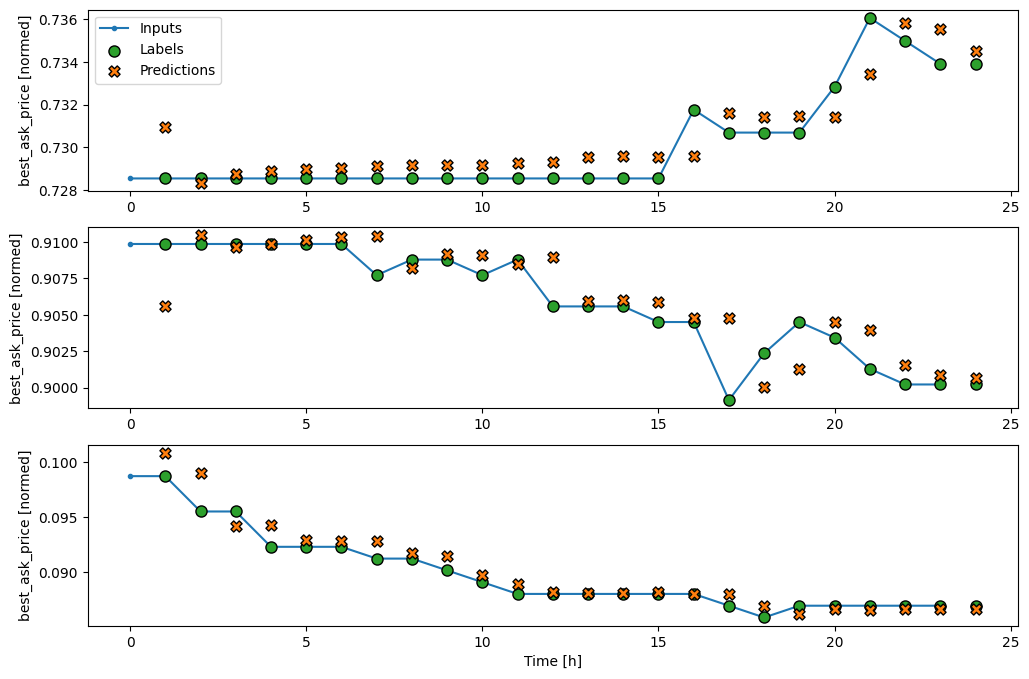

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
best_ask_price_model = lstm_model

best_ask_price_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 32)            4736      
                                                                 
 dense_5 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
wide_window_qty = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['best_ask_qty'])

wide_window_qty

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['best_ask_qty']

In [ ]:
linear_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear_2, wide_window_qty)

val_performance['Linear'] = linear.evaluate(wide_window_qty.val)
performance['Linear'] = linear.evaluate(wide_window_qty.test, verbose=0)


Epoch 1/2000
1711/1711 [==============================] - 9s 5ms/step - loss: 0.0013 - mean_absolute_error: 0.0158 - val_loss: 3.9436e-05 - val_mean_absolute_error: 0.0029
Epoch 2/2000
1711/1711 [==============================] - 8s 4ms/step - loss: 2.0316e-04 - mean_absolute_error: 0.0032 - val_loss: 3.5683e-05 - val_mean_absolute_error: 0.0027
Epoch 3/2000
1711/1711 [==============================] - 10s 6ms/step - loss: 2.0252e-04 - mean_absolute_error: 0.0032 - val_loss: 3.5629e-05 - val_mean_absolute_error: 0.0027
Epoch 4/2000
1711/1711 [==============================] - 8s 5ms/step - loss: 2.0269e-04 - mean_absolute_error: 0.0032 - val_loss: 3.6338e-05 - val_mean_absolute_error: 0.0026
Epoch 5/2000
489/489 [==============================] - 2s 3ms/step - loss: 0.6929 - mean_absolute_error: 0.8305


In [ ]:
def plot_2(self, model=None, plot_col='best_ask_qty', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot_2 = plot_2

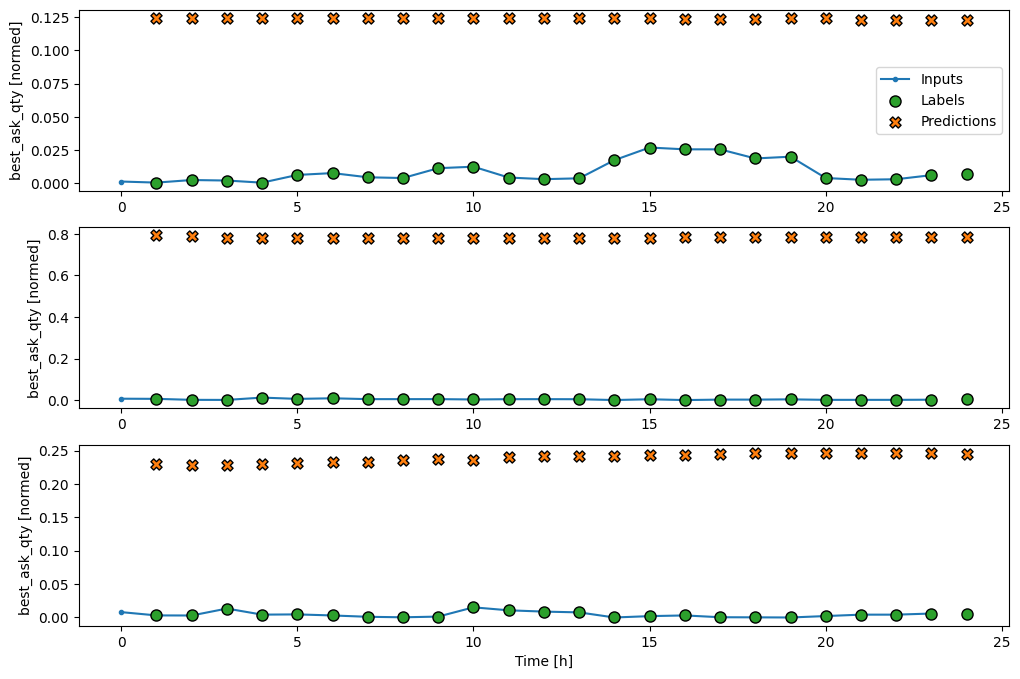

In [ ]:
wide_window_qty.plot_2(linear)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window_qty.example[0].shape)
print('Output shape:', lstm_model(wide_window_qty.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window_qty)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window_qty.val)
performance['LSTM'] = lstm_model.evaluate(wide_window_qty.test, verbose=0)

489/489 [==============================] - 5s 9ms/step - loss: 4.2640e-05 - mean_absolute_error: 0.0031


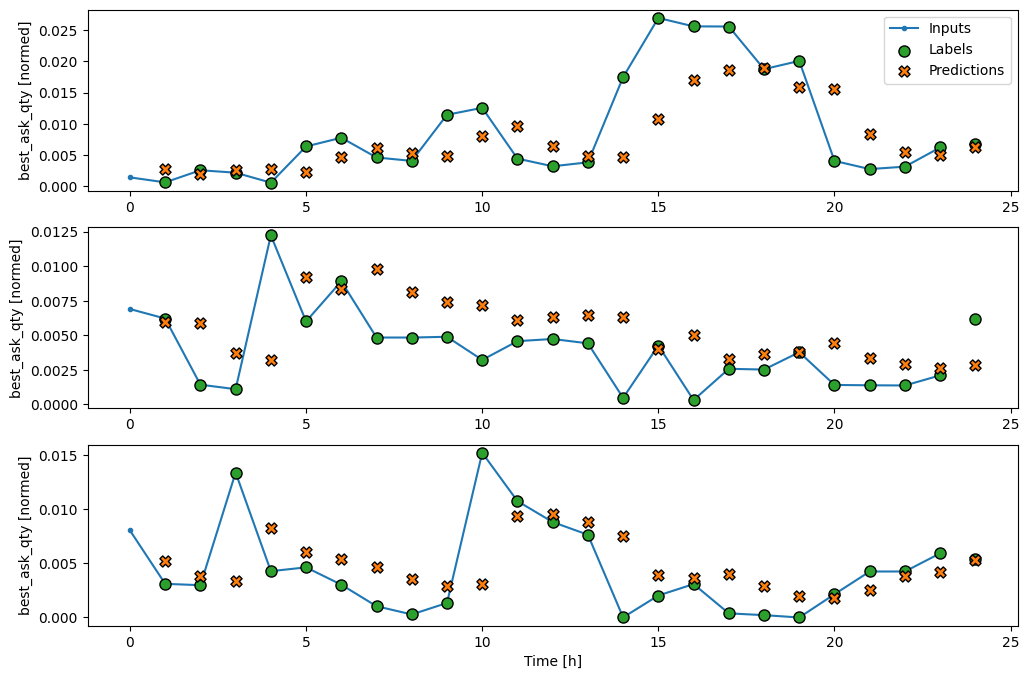

In [ ]:
wide_window_qty.plot_2(lstm_model)

In [ ]:
best_ask_qty_model = lstm_model

best_ask_qty_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 32)            4736      
                                                                 
 dense_7 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 4769 (18.63 KB)
Trainable params: 4769 (18.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Make & Compare Predictions**

First of the linear model,

In [ ]:
new_df = test_df.drop(columns=['best_ask_price'])

my_priceresult = linear.predict(x=np.array(test_df), batch_size=7826, verbose=1, steps=2)
print(my_priceresult)

my_priceresult = pd.DataFrame(my_priceresult, index=None)

my_priceresult['a'] = 0
my_priceresult['b'] = 0
my_priceresult['c'] = 0

my_priceresult = \
    scaler.inverse_transform(my_priceresult)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 12ms/step
[[0.7381128 ]
 [0.7373538 ]
 [0.73811775]
 ...
 [0.761731  ]
 [0.7617314 ]
 [0.7617314 ]]


In [ ]:
my_priceresult = pd.DataFrame(my_priceresult, index=None)
my_priceresult

,0,1,2,3
0,2421.392114,1.000000e-08,2352.1,1.000000e-08
1,2421.321374,1.000000e-08,2352.1,1.000000e-08
2,2421.392575,1.000000e-08,2352.1,1.000000e-08
3,2421.321408,1.000000e-08,2352.1,1.000000e-08
4,2421.321885,1.000000e-08,2352.1,1.000000e-08
...,...,...,...,...
7821,2423.592837,1.000000e-08,2352.1,1.000000e-08
7822,2423.593237,1.000000e-08,2352.1,1.000000e-08
7823,2423.593332,1.000000e-08,2352.1,1.000000e-08
7824,2423.593365,1.000000e-08,2352.1,1.000000e-08


In [ ]:
test_df

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
70426,0.737124,0.001168,0.740622,0.001969
70427,0.737124,0.001150,0.739550,0.002314
70428,0.737124,0.000632,0.740622,0.001969
70429,0.737124,0.001157,0.739550,0.007616
70430,0.737124,0.000632,0.739550,0.011092
...,...,...,...,...
78247,0.760730,0.000968,0.764202,0.004085
78248,0.760730,0.000500,0.764202,0.004085
78249,0.760730,0.000387,0.764202,0.004085
78250,0.760730,0.000349,0.764202,0.004085


In [ ]:
test_df_reversed = \
    scaler.inverse_transform(test_df)

test_df_reversed = pd.DataFrame(test_df_reversed, index=None)
test_df_reversed

,0,1,2,3
0,2421.3,0.915768,2421.2,0.750000
1,2421.3,0.901669,2421.1,0.881195
2,2421.3,0.495617,2421.2,0.750000
3,2421.3,0.906434,2421.1,2.900939
4,2421.3,0.495617,2421.1,4.224598
...,...,...,...,...
7821,2423.5,0.758475,2423.4,1.556057
7822,2423.5,0.392084,2423.4,1.556057
7823,2423.5,0.302943,2423.4,1.556057
7824,2423.5,0.273528,2423.4,1.556057


In [ ]:
new_df = test_df.drop(columns=['best_ask_price'])

my_qtyresult = linear.predict(x=np.array(test_df), batch_size=7826, verbose=1, steps=2)
print(my_qtyresult)

my_qtyresult = pd.DataFrame(my_qtyresult, index=None)

my_qtyresult['a'] = 0
my_qtyresult['b'] = 0
my_qtyresult['c'] = 0

my_qtyresult = \
    scaler.inverse_transform(my_qtyresult)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 9ms/step
[[0.7381128 ]
 [0.7373538 ]
 [0.73811775]
 ...
 [0.761731  ]
 [0.7617314 ]
 [0.7617314 ]]


In [ ]:
my_qtyresult = pd.DataFrame(my_qtyresult, index=None)
my_qtyresult

,0,1,2,3
0,2421.392114,1.000000e-08,2352.1,1.000000e-08
1,2421.321374,1.000000e-08,2352.1,1.000000e-08
2,2421.392575,1.000000e-08,2352.1,1.000000e-08
3,2421.321408,1.000000e-08,2352.1,1.000000e-08
4,2421.321885,1.000000e-08,2352.1,1.000000e-08
...,...,...,...,...
7821,2423.592837,1.000000e-08,2352.1,1.000000e-08
7822,2423.593237,1.000000e-08,2352.1,1.000000e-08
7823,2423.593332,1.000000e-08,2352.1,1.000000e-08
7824,2423.593365,1.000000e-08,2352.1,1.000000e-08


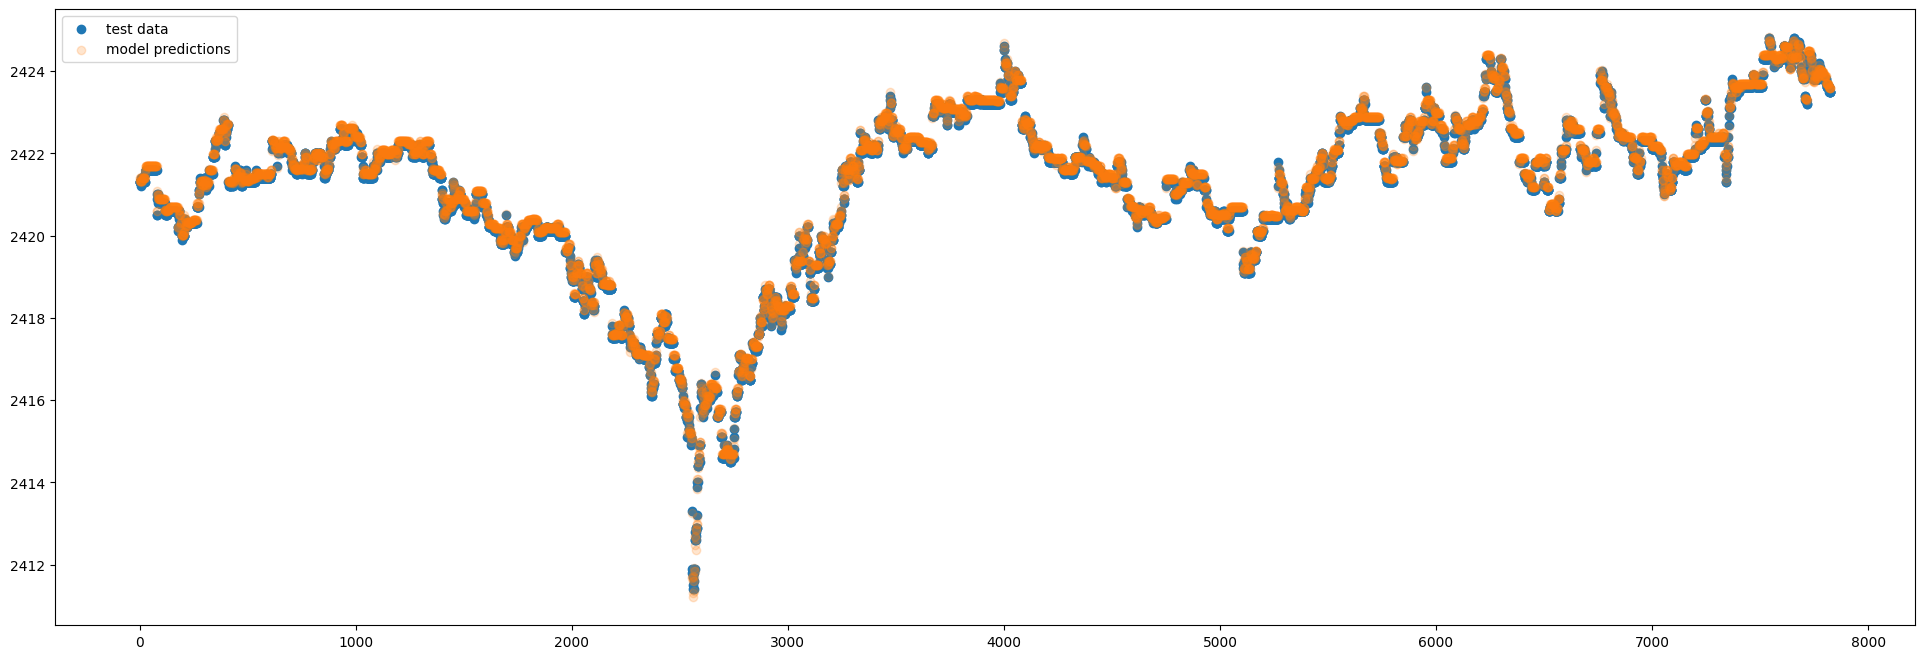

In [ ]:
# Plot comparison between Actual price and Predicted price

import matplotlib.pyplot as plt

y_axis_vals = list(range(0, 7826))

y_axis_vals = np.asarray(y_axis_vals)

#y_axis_vals = pd.DataFrame(y_axis_vals, index=None)
plt.figure(figsize=(24,8))
plt.scatter(y_axis_vals, test_df_reversed[0], label="test data")
plt.scatter(y_axis_vals, my_priceresult[0], alpha=0.2, label="model predictions")

plt.legend()

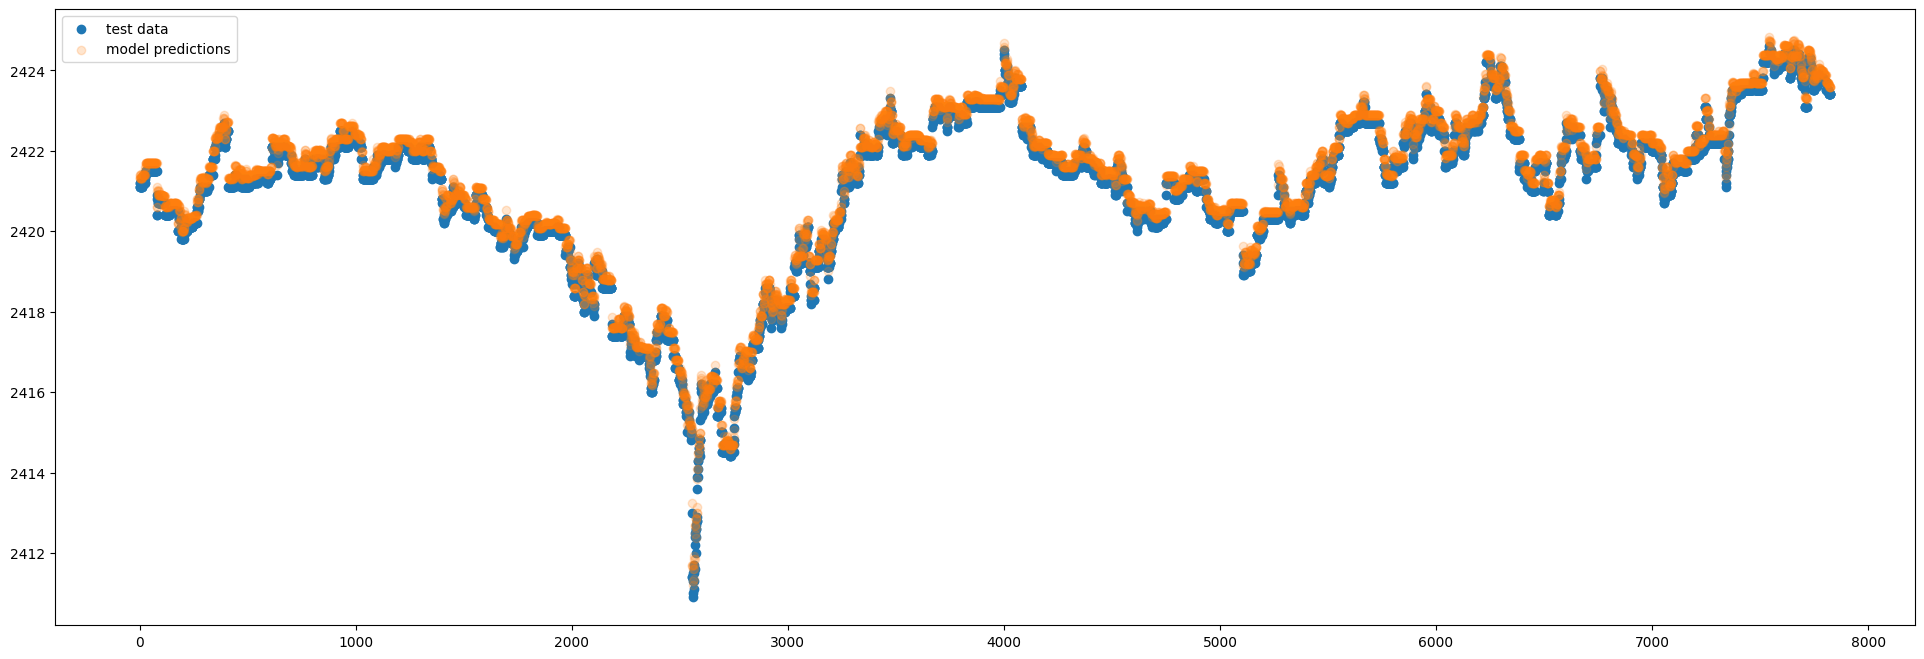

In [ ]:
# Plot comparison between Actual quantity and Predicted quantity

import matplotlib.pyplot as plt

y_axis_vals = list(range(0, 7826))

y_axis_vals = np.asarray(y_axis_vals)

#y_axis_vals = pd.DataFrame(y_axis_vals, index=None)
plt.figure(figsize=(24,8))
plt.scatter(y_axis_vals, test_df_reversed[2], label="test data")
plt.scatter(y_axis_vals, my_qtyresult[0], alpha=0.2, label="model predictions")

plt.legend()

Of the LSTM Model,

In [ ]:
x_test = tf.random.uniform(shape=(7826, 24, 4))

## **Multi Input LSTM Model I**

In [ ]:
training_data_path = '/content/drive/MyDrive/orderbook_snapshots.csv'
df_training = pd.read_csv(training_data_path)
df_training

,2024-02-07 09:00:00,57,2367.3,2.03941,49_ask
0,2024-02-07 09:00:00,56,2367.2,0.000635,48_ask
1,2024-02-07 09:00:00,55,2367.1,1.622500,47_ask
2,2024-02-07 09:00:00,53,2366.9,143.771058,46_ask
3,2024-02-07 09:00:00,52,2366.8,2.063600,45_ask
4,2024-02-07 09:00:00,50,2366.6,4.489584,44_ask
...,...,...,...,...,...
7825194,2024-02-08 09:00:00,575,2417.4,20.637439,45_bid
7825195,2024-02-08 09:00:00,572,2417.1,62.057591,46_bid
7825196,2024-02-08 09:00:00,571,2417.0,0.008275,47_bid
7825197,2024-02-08 09:00:00,570,2416.9,2.332576,48_bid


In [ ]:
# CREDIT: Sinas code to load data

# Load the data
# Input and output file names
output_filename = '/content/drive/My Drive/reformatted.csv'

# Initialise a dictionary to hold the data in correct order
orders = defaultdict(lambda: {'ask_price': None, 'ask_qty': None, 'bid_price': None, 'bid_qty': None})

# Read original csv and populate the orders dictionary
with open(training_data_path, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        timestamp, _, price, quantity, order_type = row
        if order_type == '0_ask':
            orders[timestamp]['ask_price'] = price
            orders[timestamp]['ask_qty'] = quantity
        elif order_type == '0_bid':
            orders[timestamp]['bid_price'] = price
            orders[timestamp]['bid_qty'] = quantity

# Write the data to a new csv file
with open(output_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', 'Best Ask Price Level', 'Best Ask Quantity', 'Best Bid Price Level', 'Best Bid Quantity'])
    for timestamp, order in orders.items():
        writer.writerow([timestamp, order['ask_price'], order['ask_qty'], order['bid_price'], order['bid_qty']])


data_path = output_filename
columns = ['timestamp', 'best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']
data = pd.read_csv(data_path, header=None, names=columns, skiprows=1)

# Convert timestamp to a numerical format
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y.%m.%d %H:%M:%S')
scaler = MinMaxScaler()
data[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']] = \
    scaler.fit_transform(data[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']])

data.head()
date_time = data.pop('timestamp')

data

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
0,0.097639,0.006994,0.100750,0.005718
1,0.097639,0.009870,0.100750,0.006075
2,0.097639,0.009708,0.100750,0.005741
3,0.097639,0.009935,0.100750,0.006075
4,0.097639,0.010097,0.100750,0.006075
...,...,...,...,...
78247,0.760730,0.000968,0.764202,0.004085
78248,0.760730,0.000500,0.764202,0.004085
78249,0.760730,0.000387,0.764202,0.004085
78250,0.760730,0.000349,0.764202,0.004085


In [ ]:
train_ds, test_ds = train_test_split(data, test_size=0.2, shuffle=False, random_state=2)

In [ ]:
x = train_ds
x

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
0,0.097639,0.006994,0.100750,0.005718
1,0.097639,0.009870,0.100750,0.006075
2,0.097639,0.009708,0.100750,0.005741
3,0.097639,0.009935,0.100750,0.006075
4,0.097639,0.010097,0.100750,0.006075
...,...,...,...,...
62596,0.855150,0.003254,0.857449,0.002621
62597,0.855150,0.003444,0.857449,0.001321
62598,0.860515,0.007474,0.862808,0.008722
62599,0.860515,0.007150,0.862808,0.009660


In [ ]:
in_seq1 = x[['best_ask_price']]
in_seq2 = x[['best_ask_qty']]
in_seq3 = x[['best_bid_price']]
in_seq4 = x[['best_bid_qty']]

In [ ]:
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
print(dataset)

[[0.09763948 0.00699367 0.10075027 0.00571789]
 [0.09763948 0.00987042 0.10075027 0.00607491]
 [0.09763948 0.00970834 0.10075027 0.00574139]
 ...
 [0.86051502 0.00747393 0.86280815 0.00872228]
 [0.86051502 0.00715018 0.86280815 0.00966038]
 [0.86051502 0.00696009 0.86280815 0.00578472]]


In [ ]:
n_features = 4
n_input = 2
generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=60)

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(4, activation='softplus'))

model.compile(optimizer='adam', loss='mse')

model.fit(generator, steps_per_epoch=1, epochs=10000, verbose=0)

In [ ]:
# Print some samples
print('Samples: %d' % len(generator))
for i in range(0,20):
 x, y = generator[i]
 print('%s => %s' % (x, y))

Samples: 1044
[[[0.09763948 0.00699367 0.10075027 0.00571789]
  [0.09763948 0.00987042 0.10075027 0.00607491]]

 [[0.09763948 0.00987042 0.10075027 0.00607491]
  [0.09763948 0.00970834 0.10075027 0.00574139]]

 [[0.09763948 0.00970834 0.10075027 0.00574139]
  [0.09763948 0.00993519 0.10075027 0.00607492]]

 [[0.09763948 0.00993519 0.10075027 0.00607492]
  [0.09763948 0.01009727 0.10075027 0.00607492]]

 [[0.09763948 0.01009727 0.10075027 0.00607492]
  [0.09656652 0.00216111 0.10075027 0.00607495]]

 [[0.09656652 0.00216111 0.10075027 0.00607495]
  [0.09656652 0.00216111 0.10075027 0.00607495]]

 [[0.09656652 0.00216111 0.10075027 0.00607495]
  [0.09656652 0.00403714 0.10075027 0.00607495]]

 [[0.09656652 0.00403714 0.10075027 0.00607495]
  [0.09656652 0.00403714 0.10075027 0.00607495]]

 [[0.09656652 0.00403714 0.10075027 0.00607495]
  [0.09656652 0.00403714 0.10075027 0.00607495]]

 [[0.09656652 0.00403714 0.10075027 0.00607495]
  [0.09656652 0.00488529 0.10075027 0.00607495]]

 [[0.0

In [ ]:
test_ds

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
62601,0.860515,0.006846,0.862808,0.006110
62602,0.860515,0.004804,0.862808,0.005461
62603,0.860515,0.011570,0.862808,0.002697
62604,0.860515,0.011570,0.861736,0.015677
62605,0.860515,0.011545,0.861736,0.017753
...,...,...,...,...
78247,0.760730,0.000968,0.764202,0.004085
78248,0.760730,0.000500,0.764202,0.004085
78249,0.760730,0.000387,0.764202,0.004085
78250,0.760730,0.000349,0.764202,0.004085


In [ ]:
from numpy import array
# TESTING Index 62603 and 62604 -> 62605
# Values next in sequence should be : 0.860515	0.011545	0.861736	0.017753
x_input = array([ [0.860515, 0.011570, 0.862808, 0.002697], [0.860515, 0.011570, 0.861736, 0.015677]]).reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)
yhat

array([[0.85984856, 0.00479892, 0.8599539 , 0.01110921]], dtype=float32)

In [ ]:
test_df_reversed = \
    scaler.inverse_transform(test_ds)

test_df_reversed = pd.DataFrame(test_df_reversed, index=None)
test_df_reversed

,0,1,2,3
0,2432.8,5.365910,2432.6,2.327039
1,2432.8,3.765209,2432.6,2.079983
2,2432.8,9.068144,2432.6,1.027142
3,2432.8,9.068145,2432.5,5.971263
4,2432.8,9.048087,2432.5,6.761802
...,...,...,...,...
15646,2423.5,0.758475,2423.4,1.556057
15647,2423.5,0.392084,2423.4,1.556057
15648,2423.5,0.302943,2423.4,1.556057
15649,2423.5,0.273528,2423.4,1.556057


In [ ]:
yhat = \
    scaler.inverse_transform(yhat)

yhat_result = pd.DataFrame(yhat, index=None)
yhat_result

,0,1,2,3
0,2432.737793,3.761191,2432.33374,4.231324


In [ ]:
# Use two values from the test dataset, to predict the next, then compare
from numpy import array

arr = []

for (indx1,row1),(indx2,row2),(indx3,row3) in zip(
    test_ds[:-2].iterrows(),test_ds[1:-1].iterrows(),test_ds[2:].iterrows()):
    temp1 = [row1['best_ask_price'], row1['best_ask_qty'], row1['best_bid_price'], row1['best_bid_qty']]
    temp2 = [row2['best_ask_price'], row2['best_ask_qty'], row2['best_bid_price'], row2['best_bid_qty']]
    temp3 = [row3['best_ask_price'], row3['best_ask_qty'], row3['best_bid_price'], row3['best_bid_qty']]
    x_input = array([temp1, temp2]).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=0)
    arr.append([temp3, yhat])


In [ ]:
from numpy import array
from sklearn.metrics import mean_squared_error

mean_squared_errors = []

for item in arr:
  real = item[0]
  prediction = item[1][0]
  mse = mean_squared_error(real, prediction)
  mean_squared_errors.append(mse)

average_mse = np.mean(mean_squared_errors)
print("Average mean squared error: ", f'{average_mse:.20f}')

Average mean squared error:  0.00005965769778060348


In [ ]:
# Create a df showing the predicted vs real values
# Ask and bid prices are quite accurate, Ask and bid quantities are quite off
from numpy import array

i = 0

log = []

for item in arr:
  real = item[0]
  prediction = item[1][0]
  B = array([prediction])
  yhat = \
    scaler.inverse_transform(B)
  yhat_result = pd.DataFrame(yhat, index=None)
  A = array([real])
  yhat_real = \
    scaler.inverse_transform(A)
  yhat_real = pd.DataFrame(yhat_real, index=None)
  temp = [ yhat_real[0][0], yhat_result[0][0], yhat_real[1][0], yhat_result[1][0], yhat_real[2][0], yhat_result[2][0], yhat_real[3][0], yhat_result[3][0] ]
  log.append(temp)

log_results = pd.DataFrame(log, columns=['real_ask_price', 'pred_ask_price', 'real_ask_qty', 'pred_ask_qty', 'real_bid_price', 'pred_bid_price', 'real_bid_qty', 'pred_bid_qty'])
log_results

,real_ask_price,pred_ask_price,real_ask_qty,pred_ask_qty,real_bid_price,pred_bid_price,real_bid_qty,pred_bid_qty
0,2432.8,2432.658936,9.068144,3.781383,2432.6,2432.279785,1.027142,4.171561
1,2432.8,2432.642822,9.068145,3.754295,2432.5,2432.269287,5.971263,4.134024
2,2432.8,2432.738037,9.048087,3.761188,2432.5,2432.333740,6.761802,4.231320
3,2432.8,2432.680664,4.147921,3.974233,2432.5,2432.248291,6.222197,4.558903
4,2432.8,2432.656494,4.146739,4.007456,2432.5,2432.226807,5.628972,4.579247
...,...,...,...,...,...,...,...,...
15644,2423.5,2423.414307,0.758475,4.703009,2423.4,2423.085938,1.556057,4.822447
15645,2423.5,2423.409912,0.392084,4.648263,2423.4,2423.081543,1.556057,4.736523
15646,2423.5,2423.405518,0.302943,4.685566,2423.4,2423.074707,1.556057,4.785008
15647,2423.5,2423.406006,0.273528,4.688303,2423.4,2423.074951,1.556057,4.785630


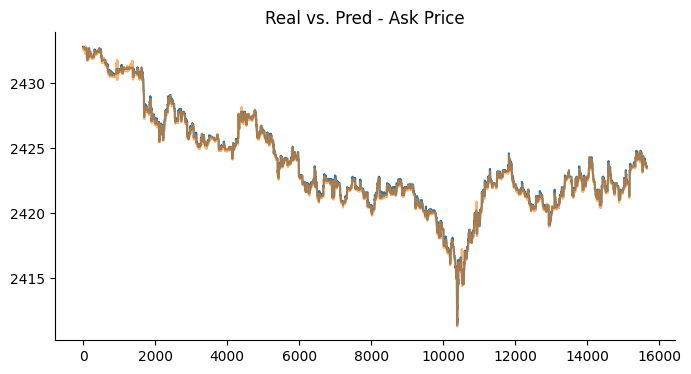

In [ ]:
# Real Ask Price vs. Predicted Ask Price

from matplotlib import pyplot as plt
log_results['real_ask_price'].plot(kind='line', figsize=(8, 4), title='Real vs. Pred - Ask Price')
plt.plot(log_results['pred_ask_price'], alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)


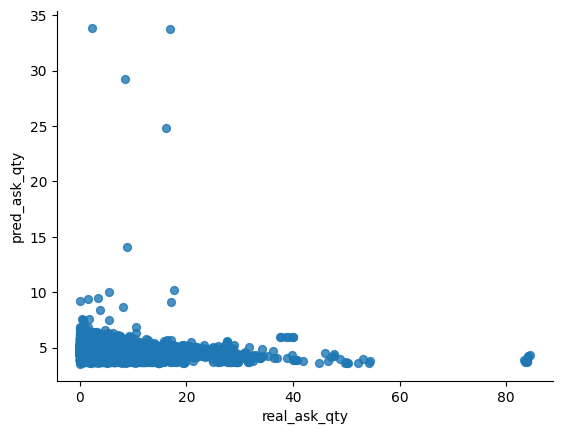

In [ ]:
# Real Ask Quantity vs Predicted Ask Quantity
from matplotlib import pyplot as plt

log_results.plot(kind='scatter', x='real_ask_qty', y='pred_ask_qty', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/multi_input_rnn_model.keras')

## **Multi Input with Added Dense Layer**

In [5]:
training_data_path = '/content/drive/MyDrive/orderbook_snapshots.csv'
df_training = pd.read_csv(training_data_path)
df_training

# Load the data
# Input and output file names
output_filename = '/content/drive/My Drive/reformatted.csv'

# Initialise a dictionary to hold the data in correct order
orders = defaultdict(lambda: {'ask_price': None, 'ask_qty': None, 'bid_price': None, 'bid_qty': None})

# Read original csv and populate the orders dictionary
with open(training_data_path, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        timestamp, _, price, quantity, order_type = row
        if order_type == '0_ask':
            orders[timestamp]['ask_price'] = price
            orders[timestamp]['ask_qty'] = quantity
        elif order_type == '0_bid':
            orders[timestamp]['bid_price'] = price
            orders[timestamp]['bid_qty'] = quantity

# Write the data to a new csv file
with open(output_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', 'Best Ask Price Level', 'Best Ask Quantity', 'Best Bid Price Level', 'Best Bid Quantity'])
    for timestamp, order in orders.items():
        writer.writerow([timestamp, order['ask_price'], order['ask_qty'], order['bid_price'], order['bid_qty']])


data_path = output_filename
columns = ['timestamp', 'best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']
data = pd.read_csv(data_path, header=None, names=columns, skiprows=1)

# Convert timestamp to a numerical format
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y.%m.%d %H:%M:%S')
scaler = MinMaxScaler()
data[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']] = \
    scaler.fit_transform(data[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']])

data.head()
date_time = data.pop('timestamp')

data

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
0,0.097639,0.006994,0.100750,0.005718
1,0.097639,0.009870,0.100750,0.006075
2,0.097639,0.009708,0.100750,0.005741
3,0.097639,0.009935,0.100750,0.006075
4,0.097639,0.010097,0.100750,0.006075
...,...,...,...,...
78247,0.760730,0.000968,0.764202,0.004085
78248,0.760730,0.000500,0.764202,0.004085
78249,0.760730,0.000387,0.764202,0.004085
78250,0.760730,0.000349,0.764202,0.004085


In [6]:
x = data
in_seq1 = x[['best_ask_price']]
in_seq2 = x[['best_ask_qty']]
in_seq3 = x[['best_bid_price']]
in_seq4 = x[['best_bid_qty']]

x

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
0,0.097639,0.006994,0.100750,0.005718
1,0.097639,0.009870,0.100750,0.006075
2,0.097639,0.009708,0.100750,0.005741
3,0.097639,0.009935,0.100750,0.006075
4,0.097639,0.010097,0.100750,0.006075
...,...,...,...,...
78247,0.760730,0.000968,0.764202,0.004085
78248,0.760730,0.000500,0.764202,0.004085
78249,0.760730,0.000387,0.764202,0.004085
78250,0.760730,0.000349,0.764202,0.004085


In [7]:
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
print(dataset)

[[9.76394850e-02 6.99366601e-03 1.00750268e-01 5.71789451e-03]
 [9.76394850e-02 9.87042307e-03 1.00750268e-01 6.07490666e-03]
 [9.76394850e-02 9.70834127e-03 1.00750268e-01 5.74138621e-03]
 ...
 [7.60729614e-01 3.86527121e-04 7.64201501e-01 4.08537908e-03]
 [7.60729614e-01 3.48996215e-04 7.64201501e-01 4.08537908e-03]
 [7.60729614e-01 3.48996215e-04 7.64201501e-01 4.08537908e-03]]


In [8]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, Conv1D
from keras.layers import Dropout
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

n_features = 4
n_input = 2
generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=60)

model = Sequential()
model.add(LSTM(64, input_shape=(n_input, n_features)))
model.add((Dense(4, activation='leaky_relu')))

model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

model.fit(generator, steps_per_epoch=1, epochs=5000, verbose=0)

In [9]:
# Print some samples
print('Samples: %d' % len(generator))
for i in range(0,20):
 x, y = generator[i]
 print('%s => %s' % (x, y))

Samples: 1305
[[[0.09763948 0.00699367 0.10075027 0.00571789]
  [0.09763948 0.00987042 0.10075027 0.00607491]]

 [[0.09763948 0.00987042 0.10075027 0.00607491]
  [0.09763948 0.00970834 0.10075027 0.00574139]]

 [[0.09763948 0.00970834 0.10075027 0.00574139]
  [0.09763948 0.00993519 0.10075027 0.00607492]]

 [[0.09763948 0.00993519 0.10075027 0.00607492]
  [0.09763948 0.01009727 0.10075027 0.00607492]]

 [[0.09763948 0.01009727 0.10075027 0.00607492]
  [0.09656652 0.00216111 0.10075027 0.00607495]]

 [[0.09656652 0.00216111 0.10075027 0.00607495]
  [0.09656652 0.00216111 0.10075027 0.00607495]]

 [[0.09656652 0.00216111 0.10075027 0.00607495]
  [0.09656652 0.00403714 0.10075027 0.00607495]]

 [[0.09656652 0.00403714 0.10075027 0.00607495]
  [0.09656652 0.00403714 0.10075027 0.00607495]]

 [[0.09656652 0.00403714 0.10075027 0.00607495]
  [0.09656652 0.00403714 0.10075027 0.00607495]]

 [[0.09656652 0.00403714 0.10075027 0.00607495]
  [0.09656652 0.00488529 0.10075027 0.00607495]]

 [[0.0

In [10]:
from numpy import array
# TESTING Index 62603 and 62604 -> 62605
# Values next in sequence should be : 0.860515	0.011545	0.861736	0.017753
x_input = array([ [0.860515, 0.011570, 0.862808, 0.002697], [0.860515, 0.011570, 0.861736, 0.015677]]).reshape((1, n_input, n_features))
yhat = model.predict(x_input, verbose=0)
yhat

array([[0.8621211 , 0.01022472, 0.8653188 , 0.01212081]], dtype=float32)

In [11]:
training_data_path = '/content/drive/MyDrive/test_orderbook_snapshots.csv'
df_training = pd.read_csv(training_data_path)
df_training

# Load the data
# Input and output file names
output_filename = '/content/drive/My Drive/reformatted_test_data.csv'

# Initialise a dictionary to hold the data in correct order
orders = defaultdict(lambda: {'ask_price': None, 'ask_qty': None, 'bid_price': None, 'bid_qty': None})

# Read original csv and populate the orders dictionary
with open(training_data_path, mode='r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        timestamp, _, price, quantity, order_type = row
        if order_type == '0_ask':
            orders[timestamp]['ask_price'] = price
            orders[timestamp]['ask_qty'] = quantity
        elif order_type == '0_bid':
            orders[timestamp]['bid_price'] = price
            orders[timestamp]['bid_qty'] = quantity

# Write the data to a new csv file
with open(output_filename, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Timestamp', 'Best Ask Price Level', 'Best Ask Quantity', 'Best Bid Price Level', 'Best Bid Quantity'])
    for timestamp, order in orders.items():
        writer.writerow([timestamp, order['ask_price'], order['ask_qty'], order['bid_price'], order['bid_qty']])


data_path = output_filename
columns = ['timestamp', 'best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']
test_ds = pd.read_csv(data_path, header=None, names=columns, skiprows=1)

# Convert timestamp to a numerical format
test_ds['timestamp'] = pd.to_datetime(test_ds['timestamp'], format='%Y.%m.%d %H:%M:%S')
scaler = MinMaxScaler()
test_ds[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']] = \
    scaler.fit_transform(test_ds[['best_ask_price', 'best_ask_qty', 'best_bid_price', 'best_bid_qty']])

test_ds.head()
date_time = test_ds.pop('timestamp')

test_ds

,best_ask_price,best_ask_qty,best_bid_price,best_bid_qty
0,0.146226,0.037831,0.141509,0.012196
1,0.141509,0.011747,0.146226,0.023583
2,0.160377,0.031189,0.160377,0.027495
3,0.169811,0.013593,0.174528,0.016098
4,0.179245,0.030354,0.169811,0.009743
...,...,...,...,...
14406,0.495283,0.042572,0.500000,0.036098
14407,0.466981,0.002018,0.471698,0.020159
14408,0.462264,0.022946,0.471698,0.013601
14409,0.462264,0.016821,0.471698,0.042998


In [12]:
test_df_reversed = \
    scaler.inverse_transform(test_ds)

test_df_reversed = pd.DataFrame(test_df_reversed, index=None)
test_df_reversed

,0,1,2,3
0,2295.2,4.887505,2294.8,1.411443
1,2295.1,1.517632,2294.9,2.729230
2,2295.5,4.029369,2295.2,3.181920
3,2295.7,1.756090,2295.5,1.862975
4,2295.9,3.921466,2295.4,1.127502
...,...,...,...,...
14406,2302.6,5.499935,2302.4,4.177536
14407,2302.0,0.260649,2301.8,2.332967
14408,2301.9,2.964416,2301.8,1.574022
14409,2301.9,2.173160,2301.8,4.976073


In [13]:
yhat = \
    scaler.inverse_transform(yhat)

yhat_result = pd.DataFrame(yhat, index=None)
yhat_result

,0,1,2,3
0,2310.376953,1.320952,2310.144775,1.402709


In [14]:
# Use two values from the test dataset, to predict the next, then compare
from numpy import array

arr = []
i = 0
for (indx1,row1),(indx2,row2),(indx3,row3) in zip(
    test_ds[:-2].iterrows(),test_ds[1:-1].iterrows(),test_ds[2:].iterrows()):
    temp1 = [row1['best_ask_price'], row1['best_ask_qty'], row1['best_bid_price'], row1['best_bid_qty']]
    temp2 = [row2['best_ask_price'], row2['best_ask_qty'], row2['best_bid_price'], row2['best_bid_qty']]
    temp3 = [row3['best_ask_price'], row3['best_ask_qty'], row3['best_bid_price'], row3['best_bid_qty']]
    x_input = array([temp1, temp2]).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=0)
    arr.append([temp3, yhat])
    print(i)
    i = i + 1


Streaming output truncated to the last 5000 lines.
9409
9410
9411
9412
9413
9414
9415
9416
9417
9418
9419
9420
9421
9422
9423
9424
9425
9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598

In [15]:
from numpy import array
from sklearn.metrics import mean_squared_error

mean_squared_errors = []

for item in arr:
  real = item[0]
  prediction = item[1][0]
  mse = mean_squared_error(real, prediction)
  mean_squared_errors.append(mse)

average_mse = np.mean(mean_squared_errors)
print("Average mean squared error: ", f'{average_mse:.20f}')

Average mean squared error:  0.00041127252696189324


In [16]:
# Create a df showing the predicted vs real values
# Ask and bid prices are quite accurate, Ask and bid quantities are quite off
from numpy import array

i = 0

log = []

for item in arr:
  real = item[0]
  prediction = item[1][0]
  B = array([prediction])
  yhat = \
    scaler.inverse_transform(B)
  yhat_result = pd.DataFrame(yhat, index=None)
  A = array([real])
  yhat_real = \
    scaler.inverse_transform(A)
  yhat_real = pd.DataFrame(yhat_real, index=None)
  temp = [ yhat_real[0][0], yhat_result[0][0], yhat_real[1][0], yhat_result[1][0], yhat_real[2][0], yhat_result[2][0], yhat_real[3][0], yhat_result[3][0] ]
  log.append(temp)

log_results = pd.DataFrame(log, columns=['real_ask_price', 'pred_ask_price', 'real_ask_qty', 'pred_ask_qty', 'real_bid_price', 'pred_bid_price', 'real_bid_qty', 'pred_bid_qty'])
log_results

,real_ask_price,pred_ask_price,real_ask_qty,pred_ask_qty,real_bid_price,pred_bid_price,real_bid_qty,pred_bid_qty
0,2295.5,2295.017822,4.029369,2.259422,2295.2,2294.806885,3.181920,1.776081
1,2295.7,2295.177002,1.756090,2.326650,2295.5,2294.960693,1.862975,2.333395
2,2295.9,2295.460205,3.921466,2.065429,2295.4,2295.240234,1.127502,1.766772
3,2295.8,2295.679688,1.910134,2.417522,2295.5,2295.449951,3.351587,1.205145
4,2295.9,2295.679688,0.262765,2.215268,2295.5,2295.464111,5.385112,2.026126
...,...,...,...,...,...,...,...,...
14404,2302.6,2302.555420,5.499935,3.746971,2302.4,2302.339111,4.177536,3.486092
14405,2302.0,2302.554199,0.260649,4.437688,2301.8,2302.339600,2.332967,3.379230
14406,2301.9,2302.333252,2.964416,1.862694,2301.8,2302.120361,1.574022,2.375227
14407,2301.9,2301.981201,2.173160,1.566192,2301.8,2301.761230,4.976073,1.631272


In [17]:
(log_results.values < 0).any()

False

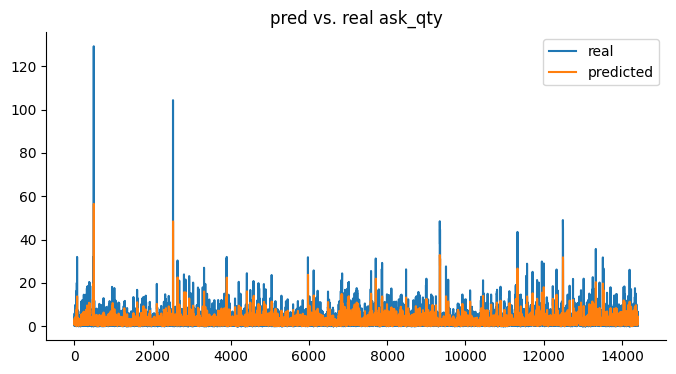

In [18]:
from matplotlib import pyplot as plt
log_results['real_ask_qty'].plot(kind='line', figsize=(8, 4), title='pred vs. real ask_qty', label="real")

log_results['pred_ask_qty'].plot(kind='line', figsize=(8, 4), label="predicted")

plt.legend()

plt.gca().spines[['top', 'right']].set_visible(False)


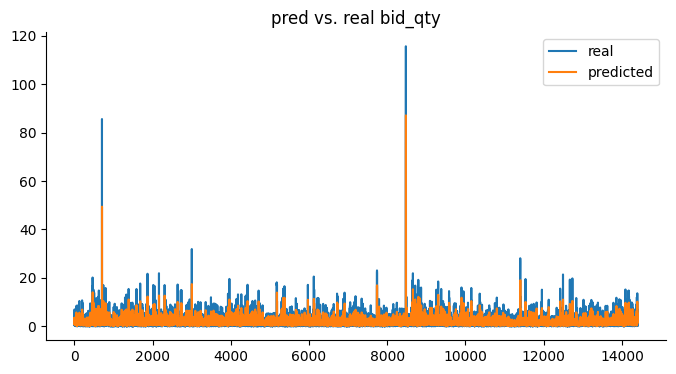

In [19]:
from matplotlib import pyplot as plt
log_results['real_bid_qty'].plot(kind='line', figsize=(8, 4), title='pred vs. real bid_qty', label="real")

log_results['pred_bid_qty'].plot(kind='line', figsize=(8, 4), label="predicted")

plt.legend()

plt.gca().spines[['top', 'right']].set_visible(False)


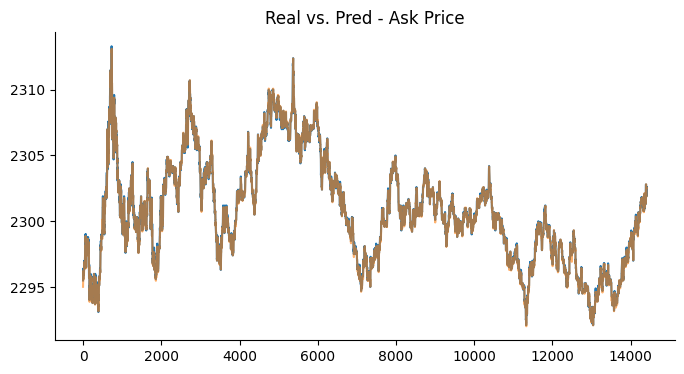

In [20]:
# Real Ask Price vs. Predicted Ask Price

from matplotlib import pyplot as plt
log_results['real_ask_price'].plot(kind='line', figsize=(8, 4), title='Real vs. Pred - Ask Price')
plt.plot(log_results['pred_ask_price'], alpha=0.6)
plt.gca().spines[['top', 'right']].set_visible(False)


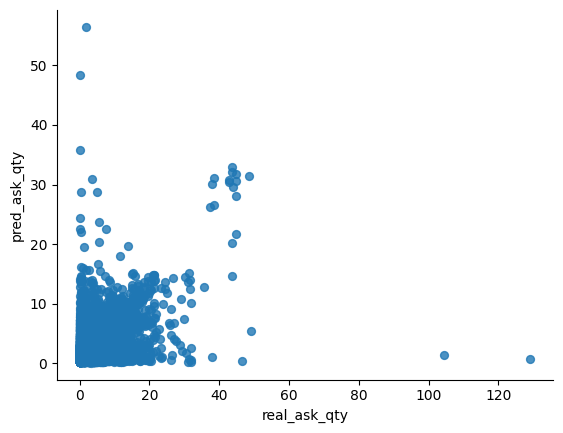

In [21]:
# Real Ask Quantity vs Predicted Ask Quantity
from matplotlib import pyplot as plt

log_results.plot(kind='scatter', x='real_ask_qty', y='pred_ask_qty', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

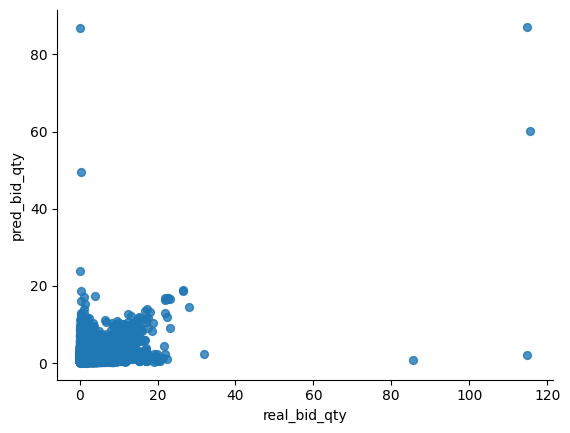

In [22]:
# Real Ask Quantity vs Predicted Ask Quantity
from matplotlib import pyplot as plt

log_results.plot(kind='scatter', x='real_bid_qty', y='pred_bid_qty', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:
# Save the model
model.save('/content/drive/MyDrive/multi_input_rnn_model_best_3.keras')